In [1]:
import os
import json
import pandas as pd
import numpy as np
import re

mvc_properties = ["ICNB", "GCNB", "LCMB", "GCPB", "LCNB"]
property_dict = {1: "ICNB", 2: "GCNB", 3: "LCMB", 4: "GCPB", 5: "LCNB"}
iv_list = [3, 4]
sl_list = [1, 2, 3, 5]
k_relax_list = [2, 3, 5]

mvc_str = "mvc_properties"
read_str = "read_behavior"
write_str = "write_behavior"
iv_str = "invisibility"
sl_str = "staleness"
tt_str = "total_time"
iv_sl_str = "iv_sl"
run_str = "RUN"
interval_str = "refresh_interval"
vp_range_str = "viewport_range"
vp_shift_str = "shift_step"
explore_str = "explore_range"
agg_value = "mean"
k_str = "k_relaxed"

notebook_home= os.path.abspath('')
experiment_home=notebook_home + "/../experiment_results"

# parse a stat report
def parse_stat_report(file_path: str):
    with open(file_path) as json_file:
        return json.load(json_file)
    
def parse_int(filename: str) -> int:
    start = re.search(r"\d", filename).start()
    return int(filename[start:])

def add_error_bound(df):
    df = df.reset_index()
    df["lower"] = df[agg_value] - df["min"]
    df["upper"] = df["max"] - df[agg_value]
    df = df.drop(["max", "min"], axis =1)
    return df

def massage_data(df, metric_type, k_relaxed = False):
    new_df = df[metric_type]/df[tt_str]
    new_df = add_error_bound(new_df)
    if k_relaxed:
        new_df = new_df[new_df[mvc_str].isin(k_relax_list)]
    elif metric_type == iv_str:
        new_df = new_df[new_df[mvc_str].isin(iv_list)]
    elif metric_type == sl_str:
        new_df = new_df[new_df[mvc_str].isin(sl_list)]
    new_df[mvc_str] = new_df[mvc_str].apply(lambda x: property_dict[x] if x in property_dict else x)
    return new_df

def read_one_file(df, root, file, dim_one, dim_two, dim_one_value):
    result = parse_stat_report(os.path.join(root, file))
    run = parse_int(os.path.basename(root))
    if dim_one_value is not None:
        dim_one_result = dim_one_value
    else:
        dim_one_result = result[dim_one]
    dim_two_result = int(result[dim_two])
    iv = float(result[iv_str])
    sl = float(result[sl_str])
    iv_sl = iv + sl
    vp_range = 6
    if vp_range_str in result:
        vp_range = float(result[vp_range_str])
    tt = float(result[tt_str])/vp_range
    df.loc[len(df.index)] = [dim_one_result, dim_two_result, run, iv, sl, iv_sl, tt]

def read_raw_data(result_home, dim_one, dim_two):
    df = pd.DataFrame(columns=[dim_one, dim_two, run_str, iv_str, sl_str, iv_sl_str, tt_str])
    for root, dirs, files in os.walk(result_home):
        for file in files:
            if file == "stat.out":
                read_one_file(df, root, file, dim_one, dim_two, None)
    return df

def read_raw_data_by_dir_name(result_home, dim_one, dim_two):
    df = pd.DataFrame(columns=[dim_one, dim_two, run_str, iv_str, sl_str, iv_sl_str, tt_str])
    for dir_name in os.listdir(result_home):
        dim_one_value = parse_int(dir_name)
        dir_root = os.path.join(result_home, dir_name)
        for root, dirs, files in os.walk(dir_root):
            for file in files:
                if file == "stat.out":
                    read_one_file(df, root, file, dim_one, dim_two, dim_one_value)
    return df

In [2]:
import matplotlib.pyplot as plt

def draw_group_bar_charts(df, group_label_header, bar_label_header, y_label, width):
    group_labels = df[group_label_header].unique()
    bar_labels = df[bar_label_header].unique()

    x = np.arange(len(group_labels))  # the group label locations
    num_bars = len(bar_labels)

    fig, ax = plt.subplots()
    for idx, bar_label in enumerate(bar_labels):
        df_subgroup = df[df[bar_label_header] == bar_label]
        err = df_subgroup[["lower", "upper"]].values.transpose()
        rect = ax.bar(x - ((num_bars - 1) * width)/2 + idx * width, df_subgroup[agg_value].values,
                      width, yerr=err, label=bar_label, ecolor="red")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_label)
    ax.set_xticks(x, group_labels)
    ax.legend()
    fig.tight_layout()
    
    plt.xticks(x, rotation=45)
    plt.show()

def plot_line_chart(df, x_axis, line_label_header, x_label, y_label):
    line_labels = df[line_label_header].unique()
    fig, ax = plt.subplots()
    for line_label in line_labels:
        df_subgroup = df[df[line_label_header] == line_label]
        err = df_subgroup[["lower", "upper"]].values.transpose()
        line = ax.errorbar(df_subgroup[x_axis].values, df_subgroup[agg_value].values, yerr=err, label=line_label)
        #line = ax.plot(df_subgroup[x_axis].values, df_subgroup[agg_value].values, label=line_label)
    ax.legend()
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    plt.show()

## Plots for different read behaviors

In [3]:
regular_change_results =  os.path.join(experiment_home, "read_behavior", "regular_change")
df = read_raw_data_by_dir_name(regular_change_results, explore_str, mvc_str)
agg_df = df.drop([run_str], axis=1).groupby([explore_str, mvc_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str)
iv_df

,explore_range,mvc_properties,mean,lower,upper
2,4.0,LCMB,0.000000,0.000000,0.000000
3,4.0,GCPB,0.271068,0.102965,0.036624
7,10.0,LCMB,0.057430,0.001396,0.000635
8,10.0,GCPB,0.415000,0.005129,0.003803
12,16.0,LCMB,0.053047,0.001322,0.000601
13,16.0,GCPB,0.712857,0.002557,0.004488
17,22.0,LCMB,0.340043,0.015368,0.019097
18,22.0,GCPB,1.222622,0.019159,0.014959


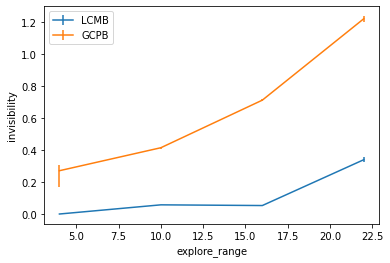

In [4]:
plot_line_chart(iv_df, explore_str, mvc_str, explore_str, iv_str)

In [5]:
sl_df = massage_data(agg_df, sl_str)
sl_df

,explore_range,mvc_properties,mean,lower,upper
0,4.0,ICNB,0.270721,0.100095,0.040438
1,4.0,GCNB,3.284868,0.053767,0.028437
2,4.0,LCMB,0.461207,0.132203,0.045231
4,4.0,LCNB,0.501792,0.000712,0.003561
5,10.0,ICNB,0.417085,0.001137,0.000119
6,10.0,GCNB,3.664275,0.130798,0.061046
7,10.0,LCMB,0.499641,-0.000359,-0.000716
9,10.0,LCNB,0.658009,0.004587,0.000111
10,16.0,ICNB,0.713773,-0.001129,0.000819
11,16.0,GCNB,3.913793,0.009031,0.017390


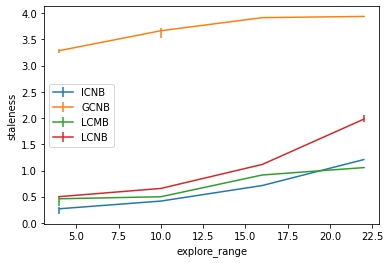

In [6]:
plot_line_chart(sl_df, explore_str, mvc_str, explore_str, sl_str)

In [7]:
see_change_results =  os.path.join(experiment_home, "read_behavior", "see_change")
df = read_raw_data_by_dir_name(see_change_results, explore_str, mvc_str)
agg_df = df.drop([run_str], axis=1).groupby([explore_str, mvc_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str)
iv_df

,explore_range,mvc_properties,mean,lower,upper
2,4.0,LCMB,0.000000,0.000000,0.000000
3,4.0,GCPB,0.304127,-0.003395,-0.000902
7,10.0,LCMB,0.228222,-0.000536,-0.000754
8,10.0,GCPB,0.525448,-0.000414,0.000303
12,16.0,LCMB,0.468146,0.006939,0.007229
13,16.0,GCPB,0.782577,0.012015,0.019147
17,22.0,LCMB,0.933094,0.013007,0.013027
18,22.0,GCPB,1.248563,0.000183,0.003050


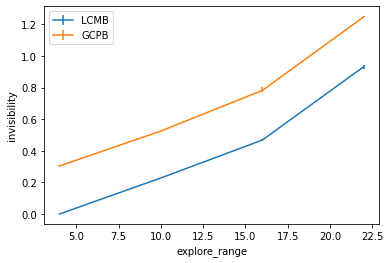

In [8]:
plot_line_chart(iv_df, explore_str, mvc_str, explore_str, iv_str)

In [9]:
sl_df = massage_data(agg_df, sl_str)
sl_df

,explore_range,mvc_properties,mean,lower,upper
0,4.0,ICNB,0.309404,0.009188,0.011026
1,4.0,GCNB,3.275341,-0.013162,0.002078
2,4.0,LCMB,0.499641,0.008262,0.007886
4,4.0,LCNB,0.508256,0.006091,0.006766
5,10.0,ICNB,0.523673,-0.001165,-0.001189
6,10.0,GCNB,3.644189,0.023500,0.012463
7,10.0,LCMB,0.524118,0.009957,0.025238
9,10.0,LCNB,1.084112,0.001861,-0.000241
10,16.0,ICNB,0.769065,0.009324,0.002978
11,16.0,GCNB,3.658713,0.013199,0.009391


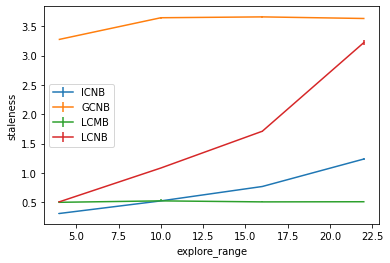

In [10]:
plot_line_chart(sl_df, explore_str, mvc_str, explore_str, sl_str)

## Plots for different viewport size

In [11]:
viewport_range =  os.path.join(experiment_home, "dash_config/viewport_range")
df = read_raw_data(viewport_range, vp_range_str, mvc_str)
df = df.sort_values([vp_range_str, mvc_str, run_str])
agg_df = df.drop([run_str], axis=1).groupby([vp_range_str, mvc_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str)
agg_df

invisibility                     staleness  \
                                      mean       min       max      mean   
viewport_range mvc_properties                                              
4.0            1.0                     0.0       0.0       0.0   56790.0   
               2.0                     0.0       0.0       0.0  180960.0   
               3.0                 12860.0    3200.0   36100.0   58080.0   
               4.0                 56640.0   54700.0   58500.0       0.0   
               5.0                     0.0       0.0       0.0   86960.0   
10.0           1.0                     0.0       0.0       0.0  102550.0   
               2.0                     0.0       0.0       0.0  419500.0   
               3.0                 14000.0   11400.0   18000.0  158800.0   
               4.0                102340.0   96800.0  109500.0       0.0   
               5.0                     0.0       0.0       0.0  234500.0   
16.0           1.0                     0.0       0.0       0.0  164420.0   
               2.0                     0.0       0.0       0.0  618060.0   
               3.0                  5360.0    4200.0    7400.0  417600.0   
               4.0                163350.0  160700.0  167200.0       0.0   
               5.0                     0.0       0.0       0.0  467160.0   
22.0           1.0                     0.0       0.0       0.0  275400.0   
               2.0                     0.0       0.0       0.0  823020.0   
               3.0                     0.0       0.0       0.0  826760.0   
               4.0                276600.0  271000.0  284400.0       0.0   
               5.0                     0.0       0.0       0.0  825440.0   

                                                      iv_sl            \
                                    min       max      mean       min   
viewport_range mvc_properties                                           
4.0            1.0              55100.0   58600.0   56790.0   55100.0   
               2.0             176400.0  184400.0  180960.0  176400.0   
               3.0              26400.0   80400.0   70940.0   62500.0   
               4.0                  0.0       0.0   56640.0   54700.0   
               5.0              82400.0   92400.0   86960.0   82400.0   
10.0           1.0              96700.0  110800.0  102550.0   96700.0   
               2.0             401200.0  436800.0  419500.0  401200.0   
               3.0             137000.0  171000.0  172800.0  154600.0   
               4.0                  0.0       0.0  102340.0   96800.0   
               5.0             224000.0  243000.0  234500.0  224000.0   
16.0           1.0             160800.0  168200.0  164420.0  160800.0   
               2.0             611600.0  628400.0  618060.0  611600.0   
               3.0             398400.0  438400.0  422960.0  405800.0   
               4.0                  0.0       0.0  163350.0  160700.0   
               5.0             453600.0  478800.0  467160.0  453600.0   
22.0           1.0             266800.0  279600.0  275400.0  266800.0   
               2.0             805200.0  844800.0  823020.0  805200.0   
               3.0             807400.0  844800.0  826760.0  807400.0   
               4.0                  0.0       0.0  276600.0  271000.0   
               5.0             816200.0  844800.0  825440.0  816200.0   

                                        total_time                    
                                    max       mean      min      max  
viewport_range mvc_properties                                         
4.0            1.0              58600.0    46720.0  46500.0  47000.0  
               2.0             184400.0    46710.0  46500.0  46900.0  
               3.0              84800.0    46730.0  46400.0  46900.0  
               4.0              58500.0    46480.0  45700.0  46900.0  
               5.0              92400.0    46370.0  45300.0  46900.0  
10.0           1.0             11

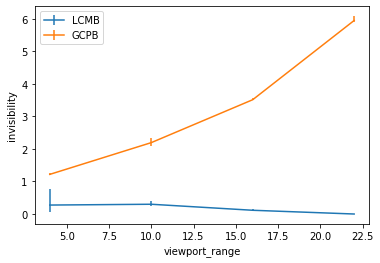

In [12]:
plot_line_chart(iv_df, vp_range_str, mvc_str, vp_range_str, iv_str)

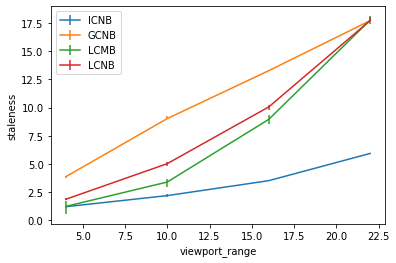

In [13]:
sl_df = massage_data(agg_df, sl_str)
plot_line_chart(sl_df, vp_range_str, mvc_str, vp_range_str, sl_str)

## Plots for different k-relaxed

In [14]:
k_path =  os.path.join(experiment_home, k_str)
df = read_raw_data(k_path, k_str, mvc_str)
df = df.sort_values([k_str, mvc_str, run_str])
agg_df = df.drop([run_str], axis=1).groupby([k_str, mvc_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str, True)
agg_df

invisibility                        staleness  \
                                  mean      min      max           mean   
k_relaxed mvc_properties                                                  
0.0       2.0                 0.000000      0.0      0.0  181600.000000   
          3.0             16566.666667  16100.0  16900.0   48933.333333   
          5.0                 0.000000      0.0      0.0   91866.666667   
2.0       2.0               800.000000    800.0    800.0  139000.000000   
          3.0             22566.666667  22400.0  22800.0   36400.000000   
          5.0             17833.333333  17500.0  18100.0   42800.000000   
4.0       2.0              4400.000000   4400.0   4400.0   98133.333333   
          3.0             56600.000000  56500.0  56700.0       0.000000   
          5.0             56900.000000  56600.0  57300.0       0.000000   
10.0      2.0             17800.000000  17700.0  18000.0   47200.000000   
          3.0             57666.666667  57100.0  58800.0       0.000000   
          5.0             56500.000000  54900.0  57900.0       0.000000   
16.0      2.0             34500.000000  30200.0  36800.0   21333.333333   
          3.0             57400.000000  56800.0  58100.0       0.000000   
          5.0             56566.666667  55100.0  58000.0       0.000000   
22.0      2.0             57366.666667  57300.0  57500.0       0.000000   
          3.0             56800.000000  56300.0  57200.0       0.000000   
          5.0             57333.333333  56800.0  57900.0       0.000000   

                                                      iv_sl            \
                               min       max           mean       min   
k_relaxed mvc_properties                                                
0.0       2.0             181200.0  182000.0  181600.000000  181200.0   
          3.0              48800.0   49200.0   65500.000000   64900.0   
          5.0              90800.0   93600.0   91866.666667   90800.0   
2.0       2.0             138400.0  139600.0  139800.000000  139200.0   
          3.0              36000.0   36800.0   58966.666667   58800.0   
          5.0              42800.0   42800.0   60633.333333   60300.0   
4.0       2.0              94000.0  100800.0  102533.333333   98400.0   
          3.0                  0.0       0.0   56600.000000   56500.0   
          5.0                  0.0       0.0   56900.000000   56600.0   
10.0      2.0              46800.0   48000.0   65000.000000   64500.0   
          3.0                  0.0       0.0   57666.666667   57100.0   
          5.0                  0.0       0.0   56500.000000   54900.0   
16.0      2.0              21200.0   21600.0   55833.333333   51400.0   
          3.0                  0.0       0.0   57400.000000   56800.0   
          5.0                  0.0       0.0   56566.666667   55100.0   
22.0      2.0                  0.0       0.0   57366.666667   57300.0   
          3.0                  0.0       0.0   56800.000000   56300.0   
          5.0                  0.0       0.0   57333.333333   56800.0   

                                      total_time                    
                               max          mean      min      max  
k_relaxed mvc_properties                                            
0.0       2.0             182000.0  46466.666667  46400.0  46500.0  
          3.0              65900.0  46466.666667  46300.0  46600.0  
          5.0              93600.0  46400.000000  46300.0  46500.0  
2.0       2.0             140400.0  46333.333333  46000.0  46700.0  
          3.0              59300.0  46433.333333  46400.0  46500.0  
          5.0              60900.0  46500.000000  46400.0  46600.0  
4.0       2.0             105200.0  46433.333333  46300.0  46500.0  
          3.0              56700.0  46266.666667  46200.0  46300.0  
          5.0              57300.0  46366.666667  46300.0  46500.0  
10.0      2.0              65700.0  46566.666667  46500.0  46600.0  
          3.0      

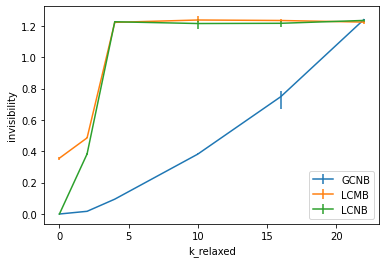

In [15]:
plot_line_chart(iv_df, k_str, mvc_str, k_str, iv_str)

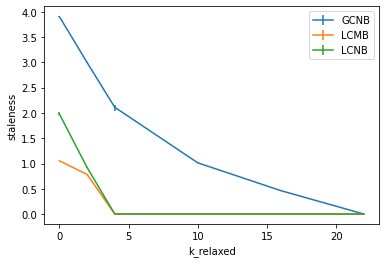

In [16]:
sl_df = massage_data(agg_df, sl_str, True)
plot_line_chart(sl_df, k_str, mvc_str, k_str, sl_str)